**This notebook is intended as a walkthrough for beginners to learn how to use boosted tree models for classification.  Some, but not all, key concepts are explored.  Although neural networks are very popular and sometimes superior, they are often not necessary or can even be inferior to a more basic approach.**

**A high level (and oversimplified) way of understanding these models is that they are basically building a series of decision trees (think CART) and then taking a weighted average of their results.  There is actually way more to it than that and it is worth taking the time to truly understand what is going on "under the hood".  However, that basic understanding is enough to build useful models.**

**First it is necessary to load the following packages.**

In [2]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from decimal import Decimal


C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


**A list of column names is constructed.  It will be applied as the data is being read.**

In [3]:

cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
        'marital_status', 'occupation', 'relationship', 'ethnicity',
        'gender', 'capital_gain', 'capital_loss', 'hours_per_week',
        'country_of_origin', 'income']

**Read in data as a pandas data frame.  This is a well known pulic data set.**

In [4]:
raw_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names = cols)


**As long as the data is not too large, it is a good idea (especially for beginners) to make a copy of the raw data.  This will allow easy checking of the before and after state of  the data after different manipulations are performed.  If this were a production pipeline, this would probably not be done.**

In [5]:
data = raw_data


**Now check that the data looks as expected at this point.**

In [6]:
data.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,gender,capital_gain,capital_loss,hours_per_week,country_of_origin,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
data.columns


Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'ethnicity', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'country_of_origin',
       'income'],
      dtype='object')

**Now the target must be defined.  This is a binary classification problem so it will be coded as 1/0.  The model itself will output a probability (between 0 and 1) when applied to data.  At that point, a method will be needed for transforming that probability into a firm prediction if the application calls for it.  For some applications (like credit scoring), the raw output is used in a different way.**

**First check the variable to be transformed**

In [8]:
data.income.value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

**There are two classes so this should be a straightforward conversion.**

In [9]:
target = np.zeros(len(data))

for i in range(len(data)):
    if data.income.values[i] == ' >50K':
        target[i] = 1
        
data['target'] = target


**Check that the conversion worked properly**

In [10]:
data.target.value_counts()

0.0    24720
1.0     7841
Name: target, dtype: int64

In [11]:
data.income.value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

**The target is set.  Now it is time to do some feature engineering.**

**The gender column currently contains text.  It will need to undergo the same transformation as our target variable.  It will be coded as as 1 for female and 0 for male.**

In [12]:
gender_num = np.zeros(len(data))

for i in range(len(data)):
    if data.gender.values[i] == ' Female':
        gender_num[i] = 1
        
data['gender_num'] = gender_num

In [13]:
data.gender.value_counts()

 Male      21790
 Female    10771
Name: gender, dtype: int64

In [14]:
data.gender_num.value_counts()

0.0    21790
1.0    10771
Name: gender_num, dtype: int64


**The workclass column has text padded with white space.  It will make life easier if we strip out the wihite space.  We will also rename the classes because they contain symbols that will not work as column names. Some classes are collapsed as they are similar.  In this case, the assumption is that information is not lost by collapsing and there is increased predictive power in unifying these categories.  This is not always the case.  Careful thought should be given to collapsing categorical features and testing of different collapsing schema should be considered.**

In [15]:
data.workclass.value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [16]:
data.workclass = data.workclass.str.strip()

data['workclass_buckets'] = data.workclass.replace(['Private' #begin old names
                                                    , 'Self-emp-not-inc'
                                                    , 'Local-gov'
                                                    , '?'
                                                    , 'State-gov'
                                                    , 'Self-emp-inc'
                                                    , 'Federal-gov'
                                                    , 'Without-pay'
                                                    , 'Never-worked'] 
                                                    , ['pvt' #begin new names
                                                    , 'self'
                                                    , 'govt'
                                                    , 'other'
                                                    , 'govt'
                                                    , 'self'
                                                    , 'govt'
                                                    , 'other'
                                                    , 'other'])

**Check that workclass collapsed properly.**

In [17]:
data.workclass_buckets.value_counts()

pvt      22696
govt      4351
self      3657
other     1857
Name: workclass_buckets, dtype: int64

**Since these features are purely categorical (no meaningful numeric assignment can be made), they will need to be one hot encoded.**

In [18]:
wcb = data.workclass_buckets
data = data.assign(wcb=wcb.values)
data.loc[:,'wcb'] = wcb.values
data = pd.get_dummies(data, columns=['wcb'])

**Check that the encoding was performed properly.**

In [19]:
data[['workclass', 'workclass_buckets',  'wcb_govt', 'wcb_self', 'wcb_pvt', 'wcb_other']].head(10)

,workclass,workclass_buckets,wcb_govt,wcb_self,wcb_pvt,wcb_other
0,State-gov,govt,1,0,0,0
1,Self-emp-not-inc,self,0,1,0,0
2,Private,pvt,0,0,1,0
3,Private,pvt,0,0,1,0
4,Private,pvt,0,0,1,0
5,Private,pvt,0,0,1,0
6,Private,pvt,0,0,1,0
7,Self-emp-not-inc,self,0,1,0,0
8,Private,pvt,0,0,1,0
9,Private,pvt,0,0,1,0


**The same process would need to be performed to include ethnicity.  A good exercise for beginners would be to go through the process of one hot encoding ethnicity and adding it to the model.**

**Now education_num will be examined.  There is also an education field which is categorical.  However, if the education_num values have numerical meaning, this would likely be a more powerful predictor.  A quick check will reveal if larger values of education_num are indicative of higher levels of education.**

In [20]:

data[['education_num', 'education']].groupby(['education_num', 'education']).count()

,
education_num,education
1,Preschool
2,1st-4th
3,5th-6th
4,7th-8th
5,9th
6,10th
7,11th
8,12th
9,HS-grad


**This results yields two important findings.  Firstly, education_num has a one to one mapping with education.  This was expected.  But as with all things data, it was still worth checking.  Also, it is pretty clear that the education_num values become larger as education level increases.  This means that the numerical values will be useful for modeling.**

**At this point feature engineering will stop and data will be split into a train and test set.  For this model, a 75%/25% split was chosen.  This is somewhat arbitrary for this application.  For other applications, there can be practical reasons why the data may need to be split differently.  In the absence of those types of constraints, most people will use something between 60%/40% and 80%/20%.  It is also worth noting that there is certainly opportunity to build more sophisticated features with this data set.  The feature engineering step is an opportunity to be creative and try new things.  In this case, some basic features were built for demonstration purposes.**

In [21]:
train, test = train_test_split(data, test_size = 0.25)

In [22]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,gender,...,hours_per_week,country_of_origin,income,target,gender_num,workclass_buckets,wcb_govt,wcb_other,wcb_pvt,wcb_self
13258,27,Private,321577,HS-grad,9,Never-married,Machine-op-inspct,Own-child,Black,Female,...,40,United-States,<=50K,0.0,1.0,pvt,0,0,1,0
16193,22,Private,174975,Assoc-voc,11,Never-married,Tech-support,Own-child,White,Female,...,36,United-States,<=50K,0.0,1.0,pvt,0,0,1,0
20232,40,Private,137304,Bachelors,13,Divorced,Adm-clerical,Not-in-family,Black,Female,...,40,United-States,<=50K,0.0,1.0,pvt,0,0,1,0
28461,25,Private,261519,HS-grad,9,Never-married,Sales,Own-child,White,Male,...,35,United-States,<=50K,0.0,0.0,pvt,0,0,1,0
8727,23,Private,214227,Assoc-voc,11,Divorced,Adm-clerical,Not-in-family,White,Female,...,30,United-States,<=50K,0.0,1.0,pvt,0,0,1,0


In [23]:
test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,gender,...,hours_per_week,country_of_origin,income,target,gender_num,workclass_buckets,wcb_govt,wcb_other,wcb_pvt,wcb_self
7544,29,Private,177651,Some-college,10,Never-married,Exec-managerial,Not-in-family,White,Male,...,45,United-States,<=50K,0.0,0.0,pvt,0,0,1,0
23770,39,State-gov,235379,Assoc-acdm,12,Divorced,Prof-specialty,Not-in-family,White,Female,...,40,United-States,<=50K,0.0,1.0,govt,1,0,0,0
23139,22,Private,252355,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,...,27,United-States,<=50K,0.0,0.0,pvt,0,0,1,0
1246,54,Self-emp-inc,166459,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,60,United-States,>50K,1.0,0.0,self,0,0,0,1
21363,49,Self-emp-not-inc,377622,Assoc-acdm,12,Divorced,Sales,Not-in-family,White,Male,...,50,United-States,<=50K,0.0,0.0,self,0,0,0,1


**A list of features is assembled to control the inputs to the model.  The list is used to subset down to only the columns that will be used as features.  Editing this list will alter which features are used as inputs to the model.  For now, the features previously examined/constructed will be used as well as a few other columns that seem like reasonable predictors.**

In [24]:
features = ['wcb_govt'
            , 'wcb_self'
            , 'wcb_pvt'
            , 'wcb_other'
            , 'education_num'
            , 'age'
            , 'gender_num'
            , 'capital_gain'
            , 'capital_loss'
            , 'hours_per_week']


**Now the data will be split again.  The built in algorithm wants the features (X) and the target (y) in separate arrays.  Both the train and test data will be split in this way so they can be input into the function.**

In [25]:
X_train = np.array(train[features])
X_test = np.array(test[features])
y_train = np.array(train['target'])
y_test = np.array(test['target'])

**A parameter grid will be set up to help tune the hyperparameters.  The numbers used are a reasonable starting point for this relatively small data set.  There are definitely more hyperparameters that could be added but these seem to make the most difference in terms of model performance.  That being said, as long as the settings are reasonable, small adjustments of these do not make much difference.  Feature engineering is far more important.  Anyway, an explanation of the hyperparameters chosen:**

**n_estimators - This controls the number of separate trees that are built.  Remember, this model is basically just building a set of decision trees and taking a weighted average of their output.  If there are complex relationships to model, more trees may be necessary.  Also note that a model with more trees will generally demand a slower learning rate.  The bottom line is that if the model is underfit, more trees should be added.  If it is overfit, the number of trees should be decreased.**


**learning_rate - This controls how quickly the cost function is optimized.  It is also referred to as shrinkage.  As stated above, the learning rate should decrease as model complexity increases.  Basic models can converge quickly (high learning rate) whereas complex models should be given time to learn relationships (low learning rate).  The bottom line here is that if the model is underfit, slow down (decrease) the learning rate.  If it is overfit, speed up (increase) the learning rate.**


**max_depth - This controls the depth of each individual decision tree and therefore controls the level of interactions that can be modeled.  Unnecessarily deep trees can lead to overfitting, but a complex feature space may demand deeper trees.**

**One strategy for tuning these is to start with a high range of values and large steps between values to cut down on the number of iterations.  After testing those values, the best iteration(s) can be determined and a tighter range with smaller steps can be tested for a more focused paramter space.**

In [26]:
param_grid_gbm = {
    'n_estimators': [20, 50, 100]
    , 'learning_rate': [.01, .05, .1]
    , 'max_depth': [2, 3, 4]
}

**The next three commands define the model type, set up the grid search across the chosen hyperparameters, and train the model respectively.**

In [27]:
model = ensemble.GradientBoostingClassifier()
gs_gbm = GridSearchCV(estimator = model
                     , param_grid = param_grid_gbm)
gs_gbm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 50, 100], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

**The code below will display the best parameterization for the training set.  Keep in mind that this may not necessarily be the best model.  If the algorithm has overfit on the training set, the model will not generalize well to the validation set.  Experience helps someone to get a "feel" for how this is going.  The only replacement for experience is meticulous attention to model performance on both train and test data sets.  The model should perform equally well on both sets.**

In [28]:
print(gs_gbm.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


**Now the best parameterization will be used to train a model.  The following two cells will show the matthews correlation coefficient for both the train and test data sets.**

In [29]:
best_gbm = gs_gbm.best_estimator_
best_gbm.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [30]:
y_pred_train = best_gbm.predict(X_train)
matthews_corrcoef(y_train, y_pred_train)

0.5765493715942639

In [31]:
y_pred_test = best_gbm.predict(X_test)
matthews_corrcoef(y_test, y_pred_test)

0.5456510170148717

**As stated above, these scores should be close.  Unless this was run with a very unusual random initialization or some type of error, the scores for this model will be similar.  A test run showed approximately .57 for train and .55 for test.  Further work could be done to determine a better model, but this is pretty good.  If these numbers were far apart, it would be wise to try less trees with less depth and a faster learning rate.  If it is believed that the model is underfit and better performance is expected, use more trees with more depth and a slower learning rate.  This can be done by adjusting the grid search or simply inputting the hyperparameters manually.  But also keep in mind, model performance usually has much more to do with feature engineering than with parameter tuning.  Also, note that all data sets are not created equal.  The quality of the data sets the ceiling and floor for model performance.**

**The next decision to make is what to do with the output.  A threshold can be set to make 1/0 assignments if that is what the use case calls for.  The usual default is to assign every proability of greater than or equal to .5 to be 1 and less than .5 to be 0.  However, this basic rule is not always optimal.  There are methods to find the optimal threshold but that is outside the scope of a beginner's treatment.  If assignment is the purpose, there are plenty of options for determning the best way to do so and the use case may impose further constraints beyond just pure accuracy.**

**Some use cases, such as credit scoring, turn the probability into a useful score.  Higher scores will imply less risk and those instances will result in more favorable loan terms.  In marketing applications, the probability of a customer making a purchase might be modeled.  There is a lot to discuss for these types of applications.  But that is far outside the scope of this treatment.**

**In this era of "black boxes" and automation, it is still important to understand what the model is doing and how it is making decisions.  GBMs are not as complex as neural nets, but it is still difficult to unpack the model and see the direct effect.  For example, the coefficients cannot simply be ported to an Excel sheet and used to calculate predictions like logistic regression.  But feature importance and partial dependence plots can give us a peak "under the hood".  They do not define exactly what the model is doing.  But they do indicate the effect a model will have on data given the inputs.**

**Feature importance reveals which predictors are having the greatest impact on making accurate predictions.  The mathematical definition is not hard to find, but it is not really important to this tutorial.  The most important thing to understand is that the feature importances will always add to 100.  Therefore, it gives no objective information about the relationship between a feature and the target.  Rather, it shows which are most important within the context of the model.  Features with low or no importance should probably be removed as they are just wasting computational resources and could even contribute to overfitting of the model.**

**The code below extracts feature importance and displays them.**

In [34]:
imp = list(np.round(best_gbm.feature_importances_*100, decimals = 1))
importance = [float(Decimal("%.1f" % e)) for e in imp]
fi = pd.DataFrame({'features': features
                  , 'importance': importance})
fi.sort_values(['importance'], ascending = False)

,features,importance
8,capital_loss,22.6
7,capital_gain,21.7
5,age,19.3
4,education_num,14.3
9,hours_per_week,12.0
6,gender_num,5.8
1,wcb_self,1.6
2,wcb_pvt,1.2
0,wcb_govt,1.0
3,wcb_other,0.5


**These results are not surprising.  Capital loss and capital gain are most important.  They are followed by age, education, and hour worked per week.  Gender seems important but the work class buckets are likely just fitting on noise.  A good exercise would be to remove them and observe the impact on the matthews correlation coefficient.**

**Partial dependence plots show the marginal effect of each predictor on the target.  They do so by getting the model output for every permutation of inputs for all other predictors at fixed values of the predictor being plotted and taking an average.  Think about integrating to find the marginal distribution of one random variable from a join distribution.  Same idea.  For numerical predictors, it is useful to examine whether it is a positive or negative relationship.  The one hot encoded predictors will simply show the impact of the 1 or 0 case as they are coded.  If relationships do not make sense, it would be wise to try to determine why counterintuitive relationships are being modeled.  It is also wise to verify that relationships are similar when partical dependence plots are constructed for both the train and test data sets.**

**The code below will create partial dependence plots for all predictors.  Note that the y-axis displays the output of the logit function.  It can easily be converted to a probability for more interpretable results.  However, the plots will look exactly the same so this format is sufficient.**

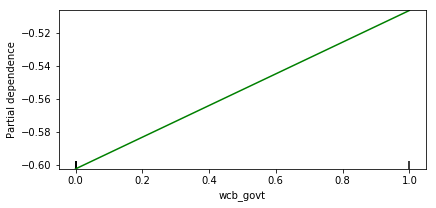

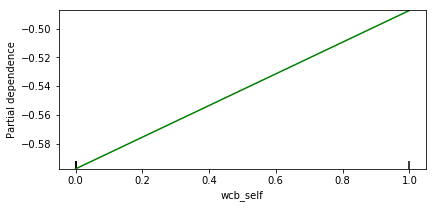

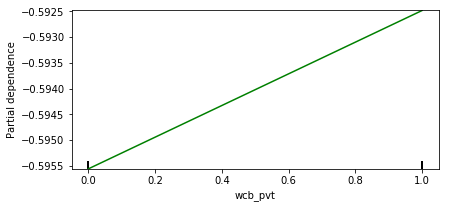

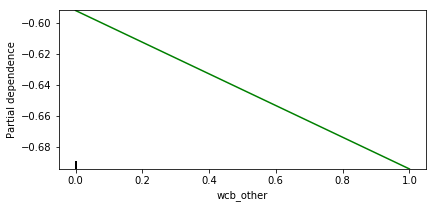

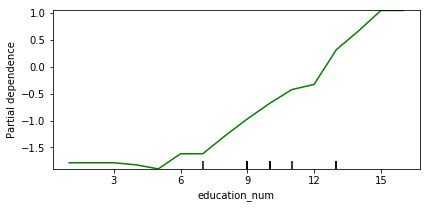

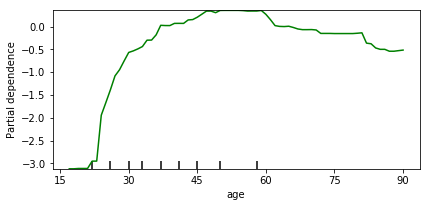

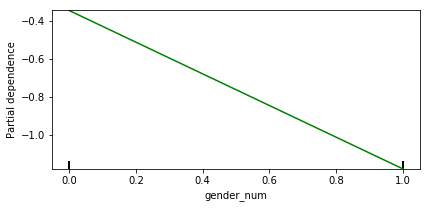

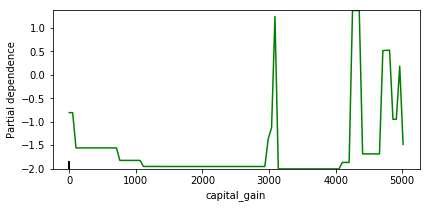

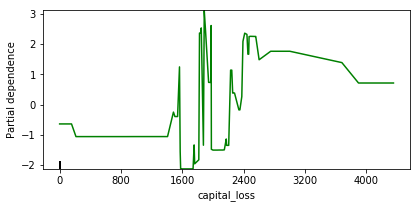

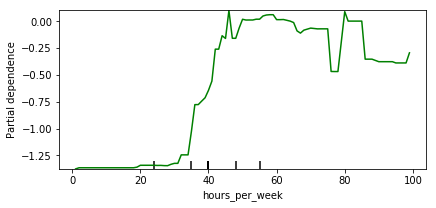

In [37]:
for i in range(len(features)):
    plot_partial_dependence(best_gbm
                           , X_train
                           , features = [i]
                           , feature_names = features)

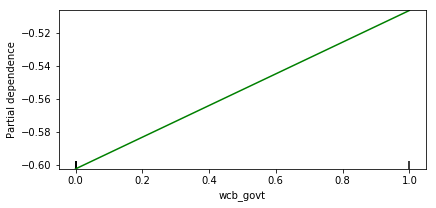

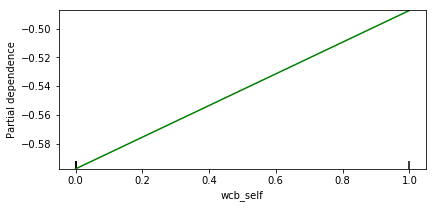

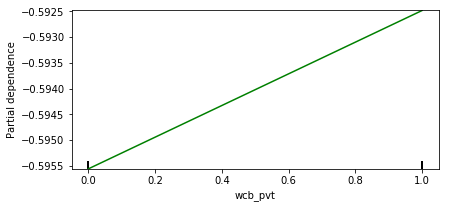

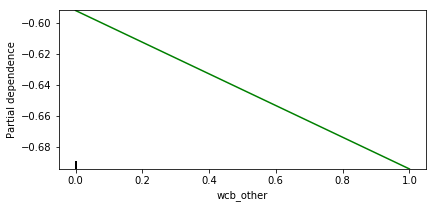

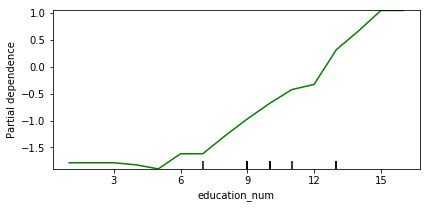

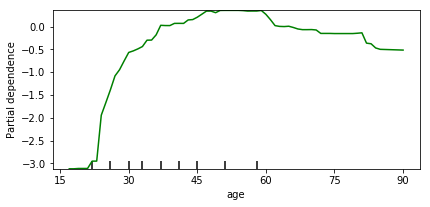

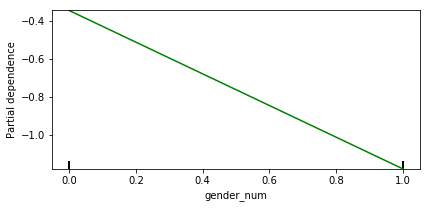

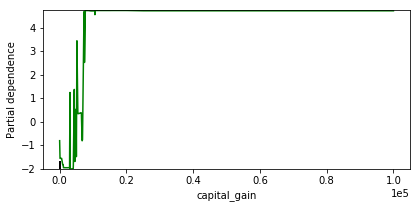

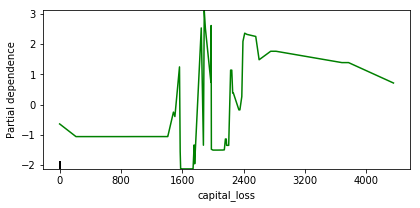

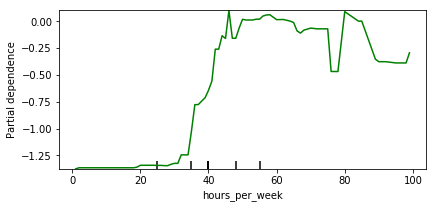

In [38]:
for i in range(len(features)):
    plot_partial_dependence(best_gbm
                           , X_test
                           , features = [i]
                           , feature_names = features)

**The partial dependence plots reveal something interesting.  The capital gain and capital loss plots are very choppy.  It seems the model has overfit on microtrends (noise), rather than modeling a simpler overall trend.  A good exercise would be to decrease the number of trees, speed up the learning rate, and/or decrease the tree depth.  Then examine the output to see if a simpler relationship has been modeled.**

**Hopefully this has been a useful beginner's tutorial.  Anyone can build useful machine learning models as long as some basic principles are understood.**